<a href="https://colab.research.google.com/github/AtSourav/CatsnDogs_VAE/blob/main/MNIST_varying_beta_l12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt


In [2]:
input_size = (28,28,1)
latent_dim = 12
batch_size = 64

In [3]:
(img_train, tg_train), (img_valid, tg_valid) = mnist.load_data()

img_ht = img_train.shape[1]
img_wd = img_train.shape[2]
count_train = img_train.shape[0]
count_valid = img_valid.shape[0]

img_train = img_train.reshape(count_train,img_ht,img_wd, 1)
img_valid = img_valid.reshape(count_valid,img_ht,img_wd, 1)

img_train = img_train/255.
img_valid = img_valid/255.

print(img_train.shape)
print(img_valid.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
# we'll keep a train:valid split of 80:20, so we'll keep only 40k of the training images.

In [4]:
img_train = img_train[:40000]
print(img_train.shape)

(40000, 28, 28, 1)


In [5]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(8, 2, padding="valid")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")(x)    # with strides=None this defaults to pool_size
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization(axis=-1)(x) # the default data_format in the conv2d is "channels last", we want to normalize across the channels, hence we set axis=-1
x = layers.ReLU()(x)

x = layers.Conv2D(16, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid")(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="valid")(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

#x = layers.Dense(8*latent_dim)(x)
x = layers.Dense(2*latent_dim)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])   # we feed the sampling function in to a Lambda layer to build form a layer for the architecture as keras needs

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')           # the second argument specifies that the encoder outputs [z_mean, z_log_var, z] for each input.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 27, 27, 8)            40        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)            0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 re_lu (ReLU)                (None, 14, 14, 8)            0         ['max_pooling2d[0][0]'] 

In [6]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Dense(32)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Dense(64)(x)
# = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Reshape((1,1,64))(x)

x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(8, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(1, 2, activation='sigmoid', strides=2, padding='same')(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 re_lu_6 (ReLU)              (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                800       
                                                                 
 re_lu_7 (ReLU)              (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 re_lu_8 (ReLU)              (None, 64)                0   

In [7]:
decoder_out = decoder(encoder(encoder_input)[2])          # we feed in z from the encoder output
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 12),              17192     
                              (None, 12),                        
                              (None, 12)]                        
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         18193     
                                                                 
Total params: 35385 (138.22 KB)
Trainable params: 35385 (138.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **beta = 1**

In [ ]:
beta=1

def vae_loss_1(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [ ]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.993, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_1)

In [ ]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=250, steps_per_epoch=None)

Epoch 1/150
625/625 [==============================] - 28s 15ms/step - loss: 223.4176 - val_loss: 195.8358
Epoch 2/150
625/625 [==============================] - 8s 12ms/step - loss: 192.5224 - val_loss: 188.8704
Epoch 3/150
625/625 [==============================] - 8s 12ms/step - loss: 183.0699 - val_loss: 177.0877
Epoch 4/150
625/625 [==============================] - 7s 11ms/step - loss: 174.4982 - val_loss: 171.5520
Epoch 5/150
625/625 [==============================] - 8s 12ms/step - loss: 170.3591 - val_loss: 167.8737
Epoch 6/150
625/625 [==============================] - 7s 12ms/step - loss: 164.3684 - val_loss: 160.2900
Epoch 7/150
625/625 [==============================] - 8s 12ms/step - loss: 157.4014 - val_loss: 154.8969
Epoch 8/150
625/625 [==============================] - 7s 12ms/step - loss: 153.3444 - val_loss: 151.7587
Epoch 9/150
625/625 [==============================] - 7s 12ms/step - loss: 150.9458 - val_loss: 149.7569
Epoch 10/150
625/625 [=======================

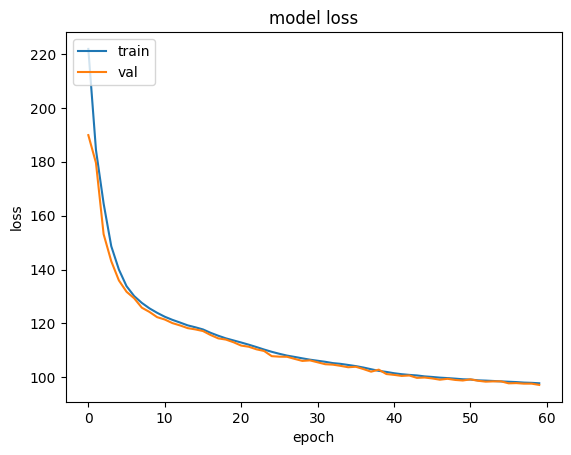

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 100)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  _,_,z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  digits_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  digits_recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

  digits_recon.tight_layout()

  for i in range(210):
    digits_recon.add_subplot(10,21,i+1)
    j = int(np.floor(i/21))
    if (i%21) <10:
      img = set[tg_indices[j*10 + (i%21)]]
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    elif (i%21)==10:
      img = np.ones((14,14,1))
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    else:
      img = img_recon[j*10 + (i%21) - 11]
      plt.imshow(img, cmap='gray')
      plt.axis('off')

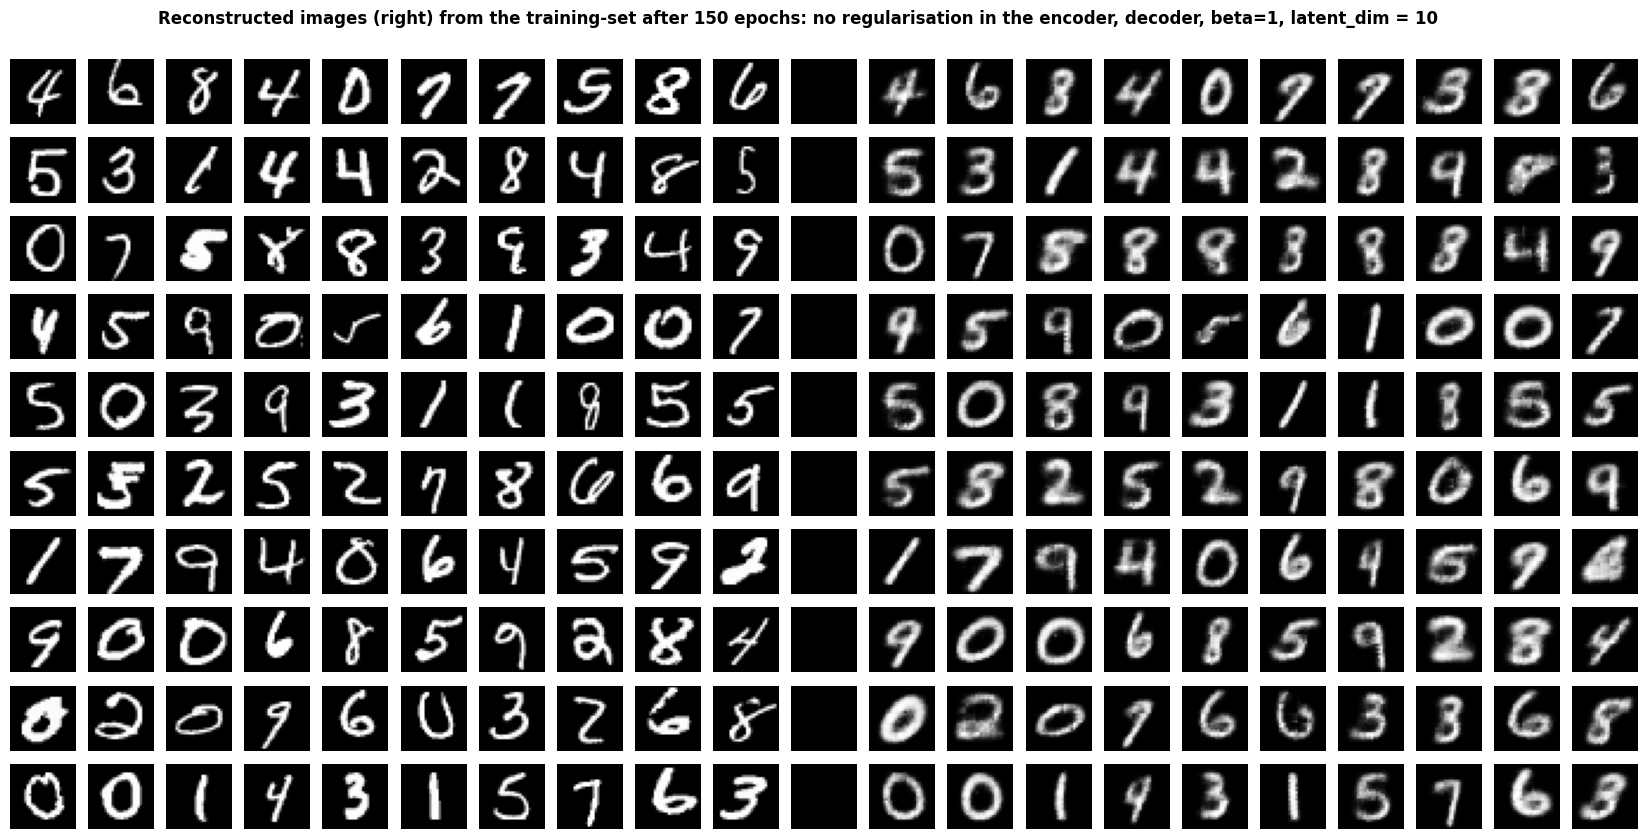

In [ ]:
plot_reconstruction(img_train,'training',200,150)

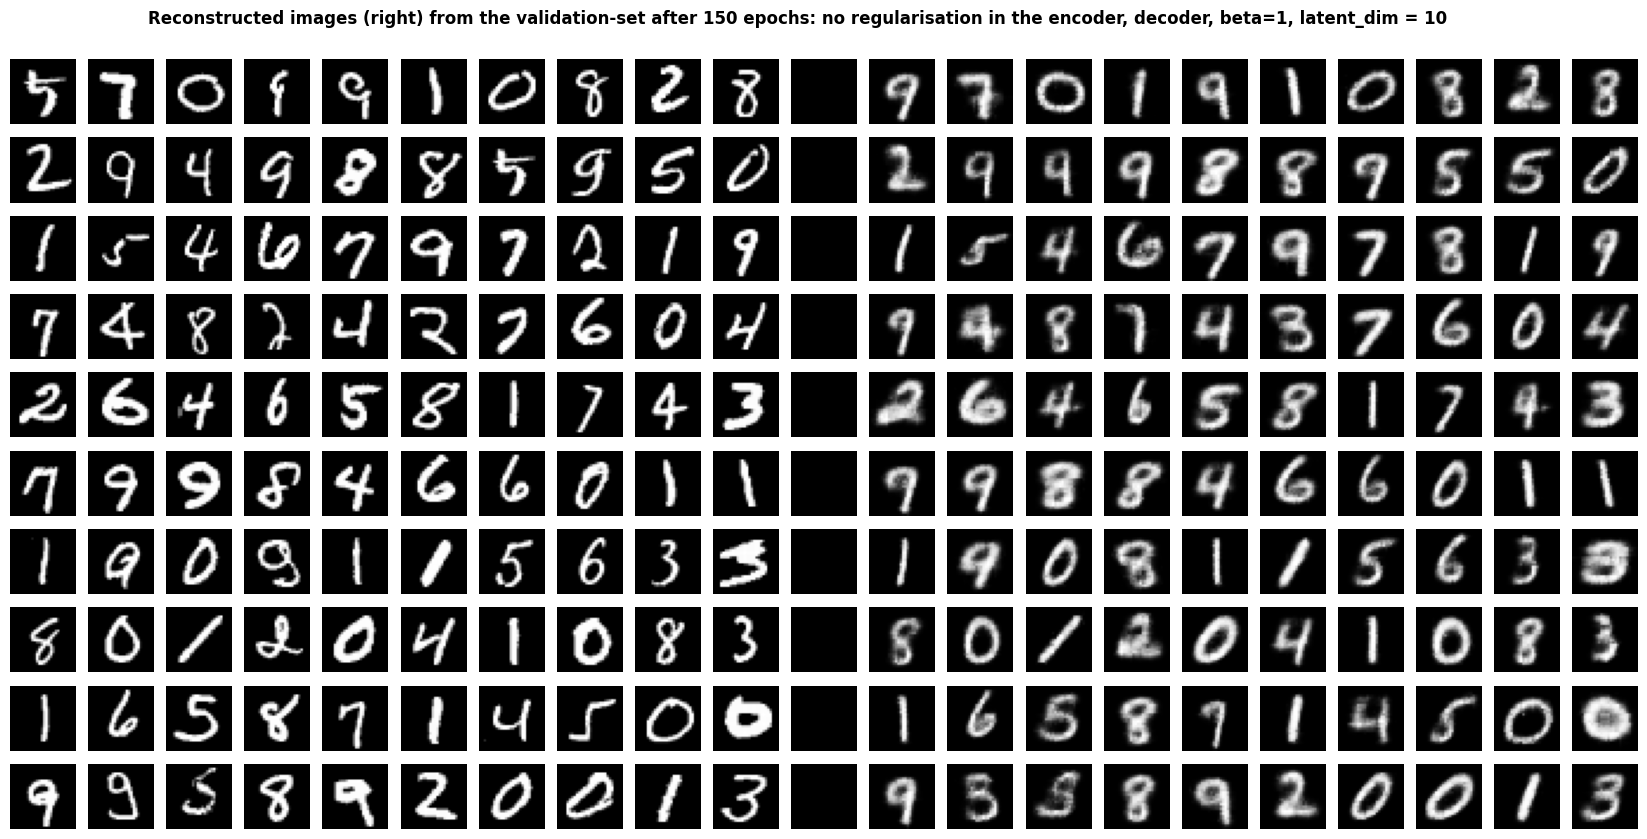

In [ ]:
plot_reconstruction(img_valid,'validation',500,150)

In [ ]:
def plot_generated(scale,edge, seed_val, epochs):   # edge is the length of the square grid we want to create
  np.random.seed(seed_val)
  z_rand = tf.convert_to_tensor(-scale + 2*scale*np.random.random((edge**2,latent_dim)))

  img_rand = decoder(z_rand)

  digits_rand = plt.figure(figsize=(edge,edge))
  digits_rand.suptitle('Some randomly generated images (after '+ str(epochs) + ' epochs of training): no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)


  for i in range(edge**2):
    digits_rand.add_subplot(edge,edge,i+1)
    img = img_rand[i]
    plt.imshow(img, cmap='gray')
    plt.axis('off')



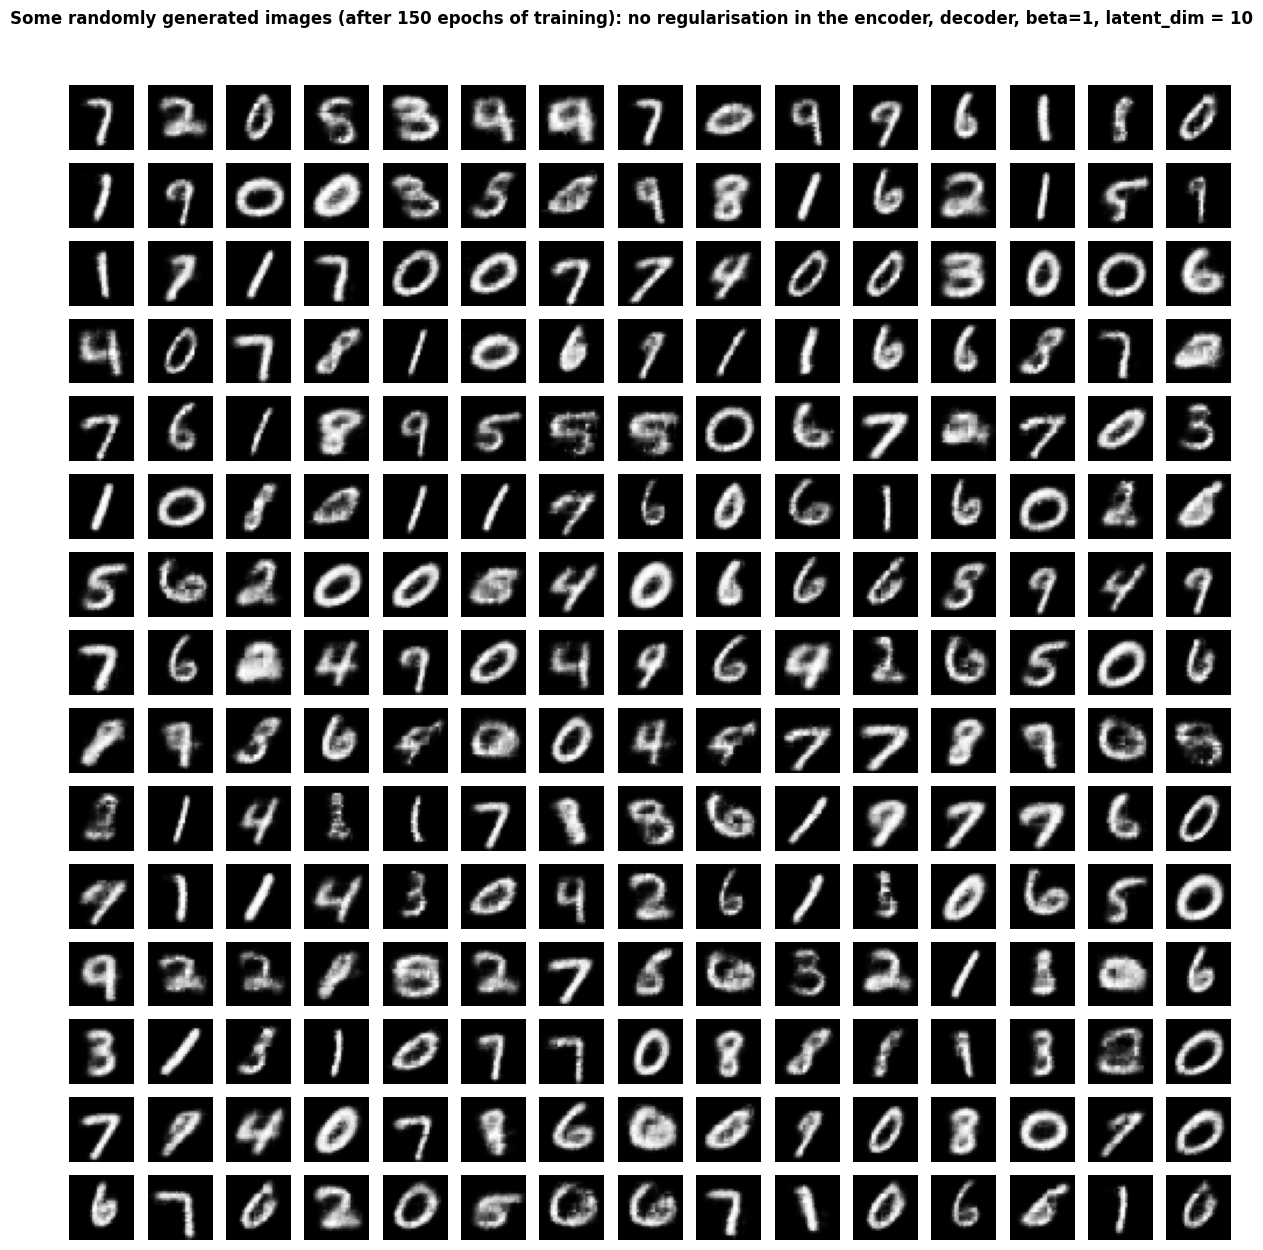

In [ ]:
 plot_generated(2,15,111,150)

From an inspection of the images, it seems like the training set images are indeed reconstructed slightly better than the validation set images. This is understandable as the loss plots seems to indicate that the performance is very slightly better on the training set than on the validation set.   

We shall take this to further extremes by taking a low value of beta which should suppress the kl div term w.r.t. the reconstruction term.

## **beta=0.01**

In [ ]:
beta=0.01

def vae_loss_2(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [ ]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.994, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_2)

In [ ]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=200, steps_per_epoch=None)

Epoch 1/100
625/625 [==============================] - 8s 13ms/step - loss: 86.4874 - val_loss: 86.6367
Epoch 2/100
625/625 [==============================] - 8s 12ms/step - loss: 86.4508 - val_loss: 86.6026
Epoch 3/100
625/625 [==============================] - 8s 12ms/step - loss: 86.4274 - val_loss: 86.3261
Epoch 4/100
625/625 [==============================] - 8s 13ms/step - loss: 86.4770 - val_loss: 86.0894
Epoch 5/100
625/625 [==============================] - 8s 13ms/step - loss: 86.3500 - val_loss: 86.0681
Epoch 6/100
625/625 [==============================] - 8s 13ms/step - loss: 86.3715 - val_loss: 86.1413
Epoch 7/100
625/625 [==============================] - 8s 13ms/step - loss: 86.3885 - val_loss: 86.2913
Epoch 8/100
625/625 [==============================] - 7s 12ms/step - loss: 86.3410 - val_loss: 86.8559
Epoch 9/100
625/625 [==============================] - 8s 13ms/step - loss: 86.2984 - val_loss: 86.3078
Epoch 10/100
625/625 [==============================] - 10s 15ms

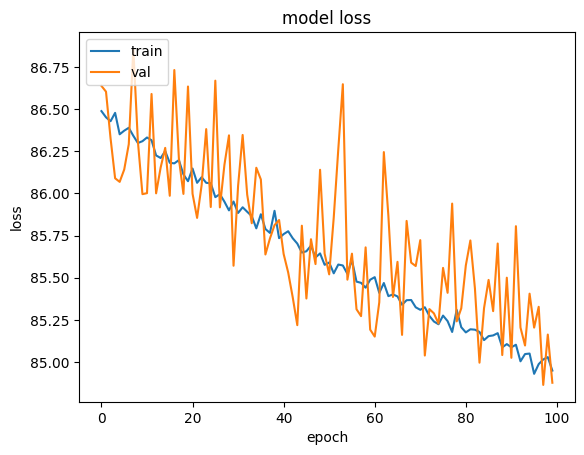

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

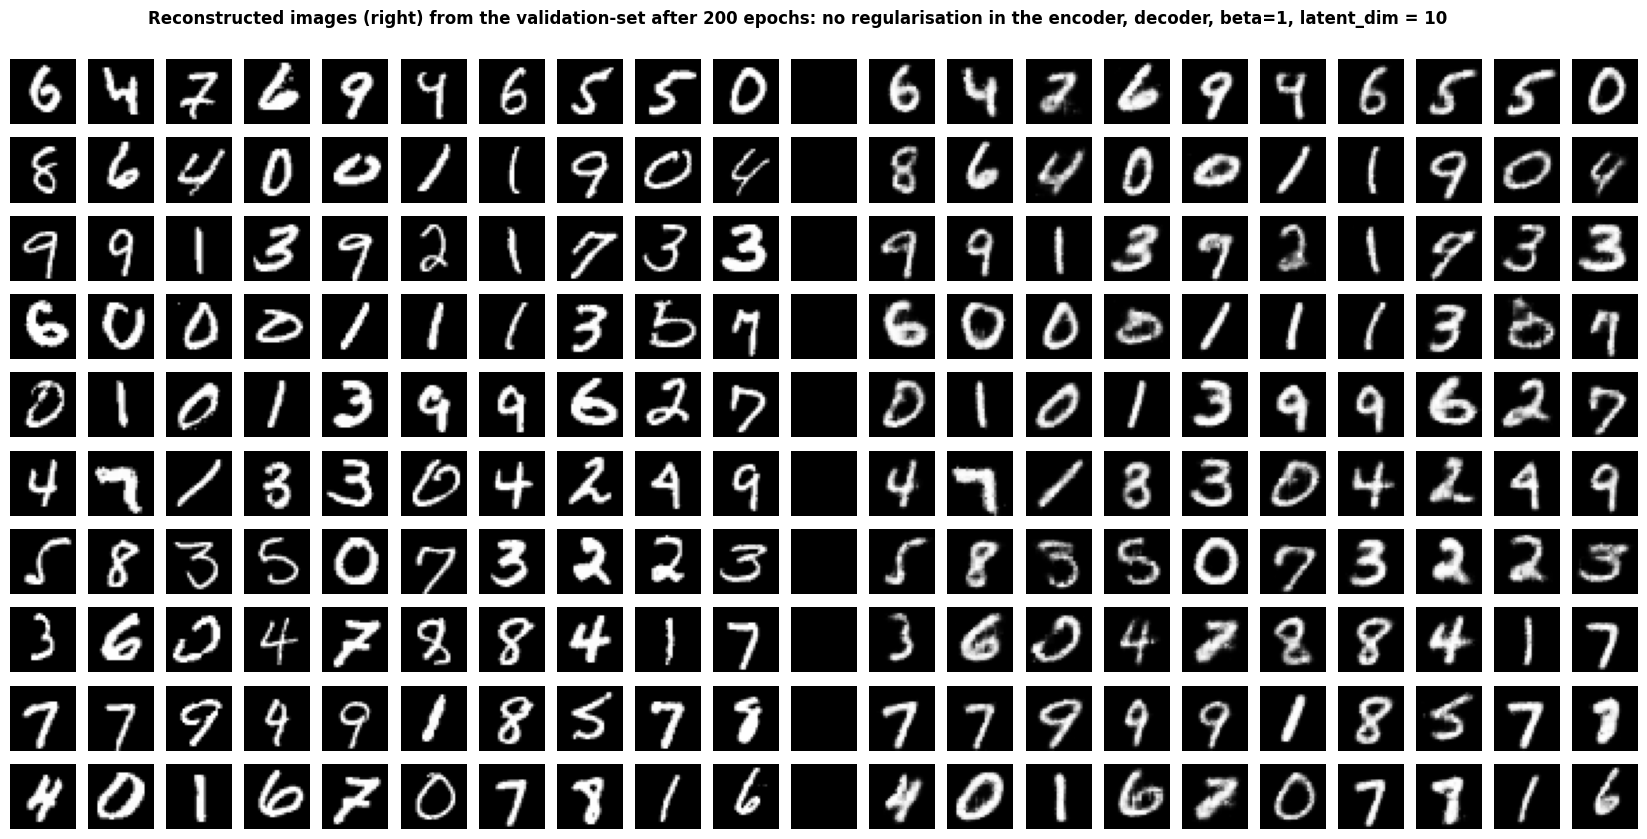

In [ ]:
plot_reconstruction(img_valid,'validation',200,200)

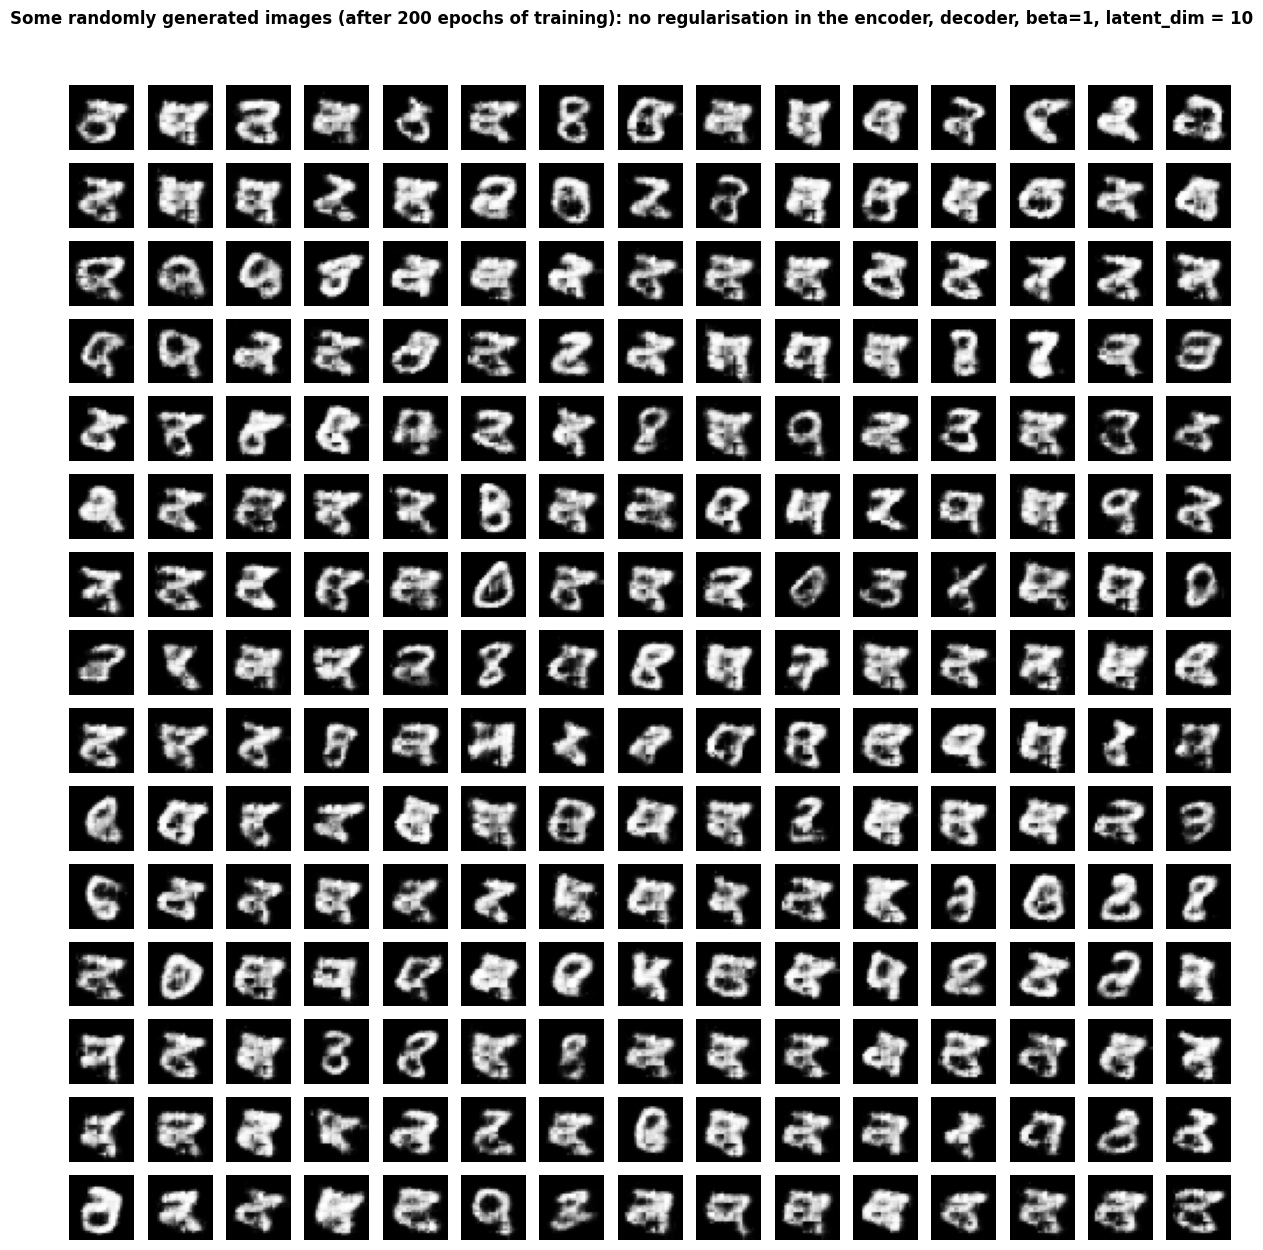

In [ ]:
plot_generated(1,15,111,200)

In [ ]:
# the quality of the generated images is really bad as expected

## **beta=10**

In [ ]:
beta=10

def vae_loss_3(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [ ]:
#lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.994, staircase=True)
optim = keras.optimizers.Adam(learning_rate = 0.0005)
VAE.compile(optimizer=optim,loss=vae_loss_3)

In [ ]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=40, steps_per_epoch=None)

Epoch 1/40
625/625 [==============================] - 23s 13ms/step - loss: 253.0892 - val_loss: 207.8853
Epoch 2/40
625/625 [==============================] - 7s 11ms/step - loss: 207.4706 - val_loss: 206.5333
Epoch 3/40
625/625 [==============================] - 7s 12ms/step - loss: 206.6438 - val_loss: 205.7337
Epoch 4/40
625/625 [==============================] - 7s 11ms/step - loss: 204.7777 - val_loss: 203.0781
Epoch 5/40
625/625 [==============================] - 7s 11ms/step - loss: 202.7267 - val_loss: 201.6659
Epoch 6/40
625/625 [==============================] - 7s 12ms/step - loss: 201.7138 - val_loss: 200.9308
Epoch 7/40
625/625 [==============================] - 7s 11ms/step - loss: 200.9452 - val_loss: 200.1940
Epoch 8/40
625/625 [==============================] - 7s 12ms/step - loss: 200.3535 - val_loss: 199.6430
Epoch 9/40
625/625 [==============================] - 7s 11ms/step - loss: 199.8502 - val_loss: 199.2645
Epoch 10/40
625/625 [==============================] -

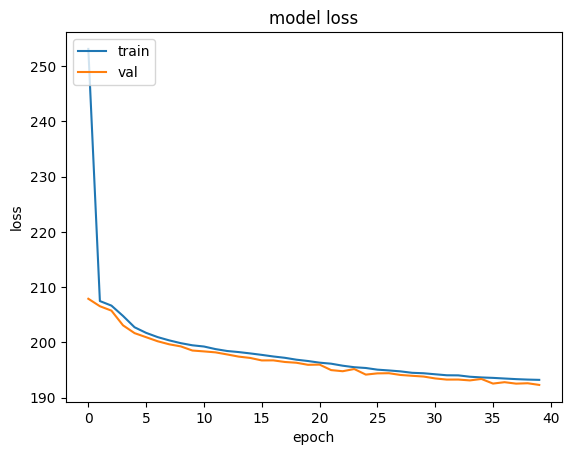

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

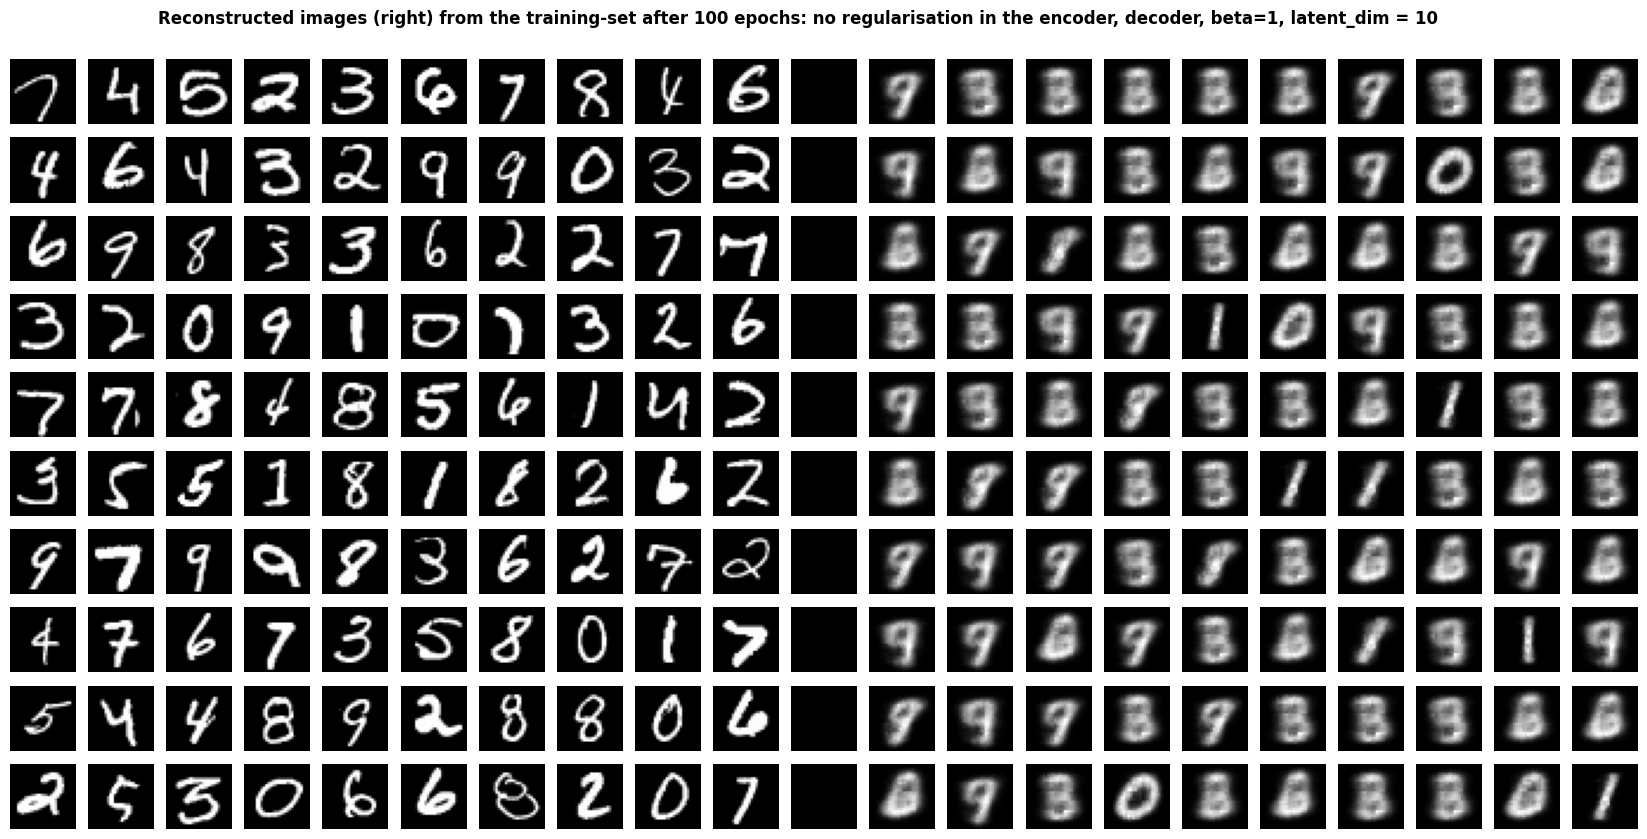

In [ ]:
plot_reconstruction(img_train,'training',111,100)

In [ ]:
# quality of reconstruction is bad

# **beta=5**

In [10]:
beta=5

def vae_loss_4(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [21]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=50000, decay_rate=0.99, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_4)

In [12]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=300, steps_per_epoch=None)

Epoch 1/300
625/625 [==============================] - 30s 43ms/step - loss: 230.9595 - val_loss: 202.2103
Epoch 2/300
625/625 [==============================] - 29s 46ms/step - loss: 198.8307 - val_loss: 196.3400
Epoch 3/300
625/625 [==============================] - 27s 43ms/step - loss: 195.5452 - val_loss: 194.2262
Epoch 4/300
625/625 [==============================] - 26s 42ms/step - loss: 193.6913 - val_loss: 192.2097
Epoch 5/300
625/625 [==============================] - 26s 42ms/step - loss: 191.9031 - val_loss: 190.0694
Epoch 6/300
625/625 [==============================] - 26s 42ms/step - loss: 190.4466 - val_loss: 188.9549
Epoch 7/300
625/625 [==============================] - 26s 42ms/step - loss: 189.1901 - val_loss: 187.2428
Epoch 8/300
625/625 [==============================] - 27s 43ms/step - loss: 187.5650 - val_loss: 186.1371
Epoch 9/300
625/625 [==============================] - 26s 42ms/step - loss: 185.7171 - val_loss: 184.2002
Epoch 10/300
625/625 [===============

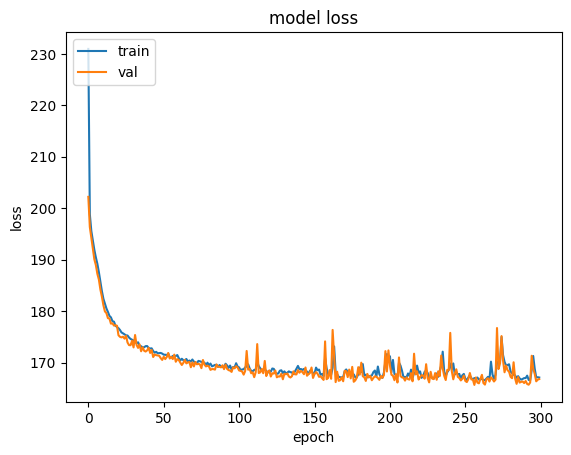

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

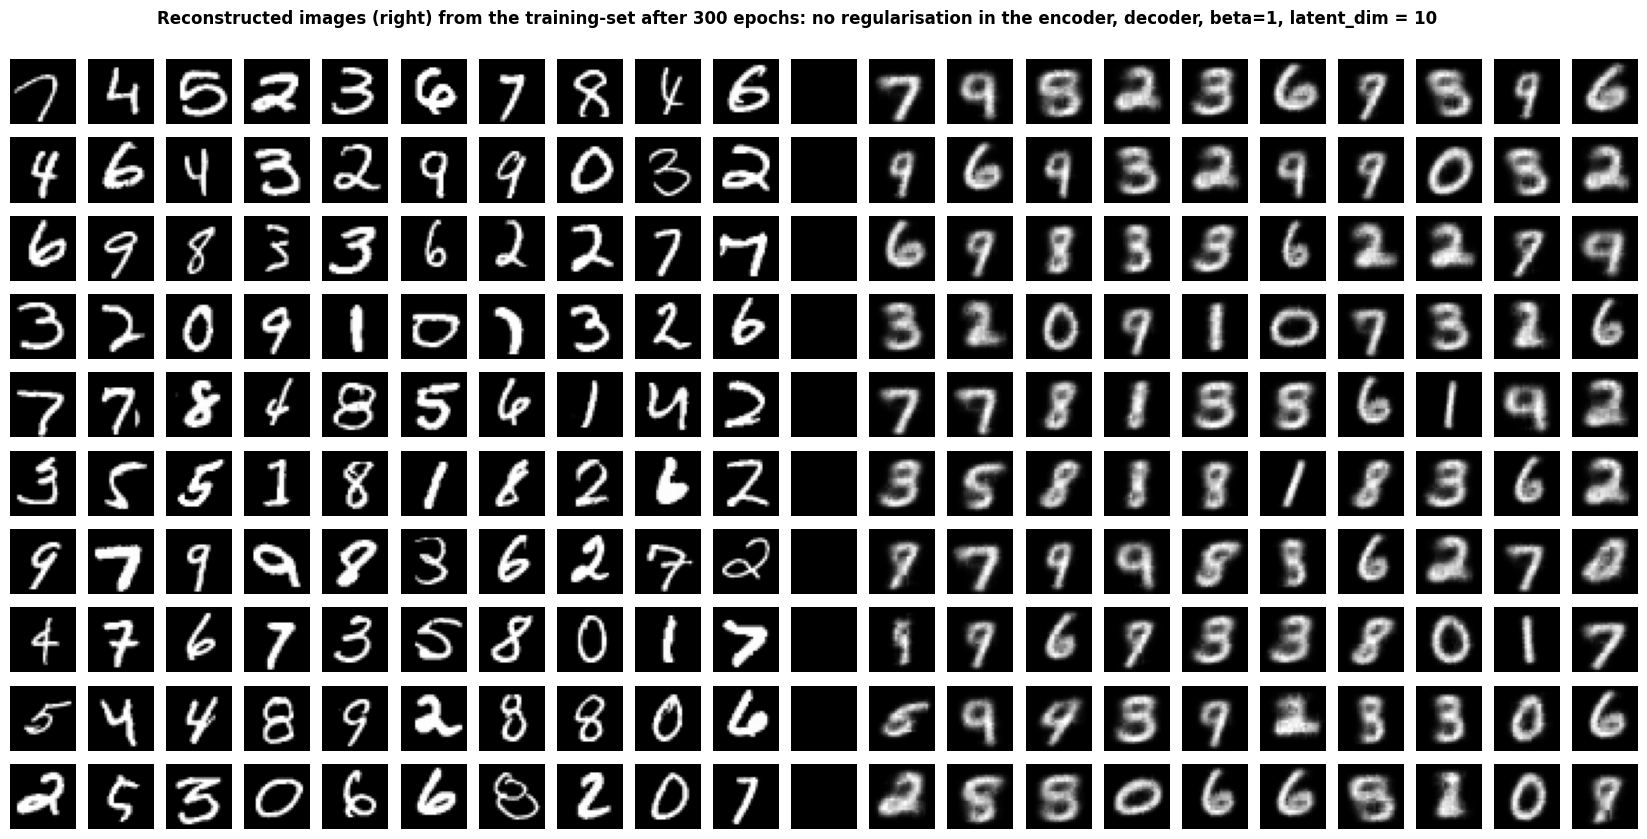

In [15]:
plot_reconstruction(img_train,'training',111,300)

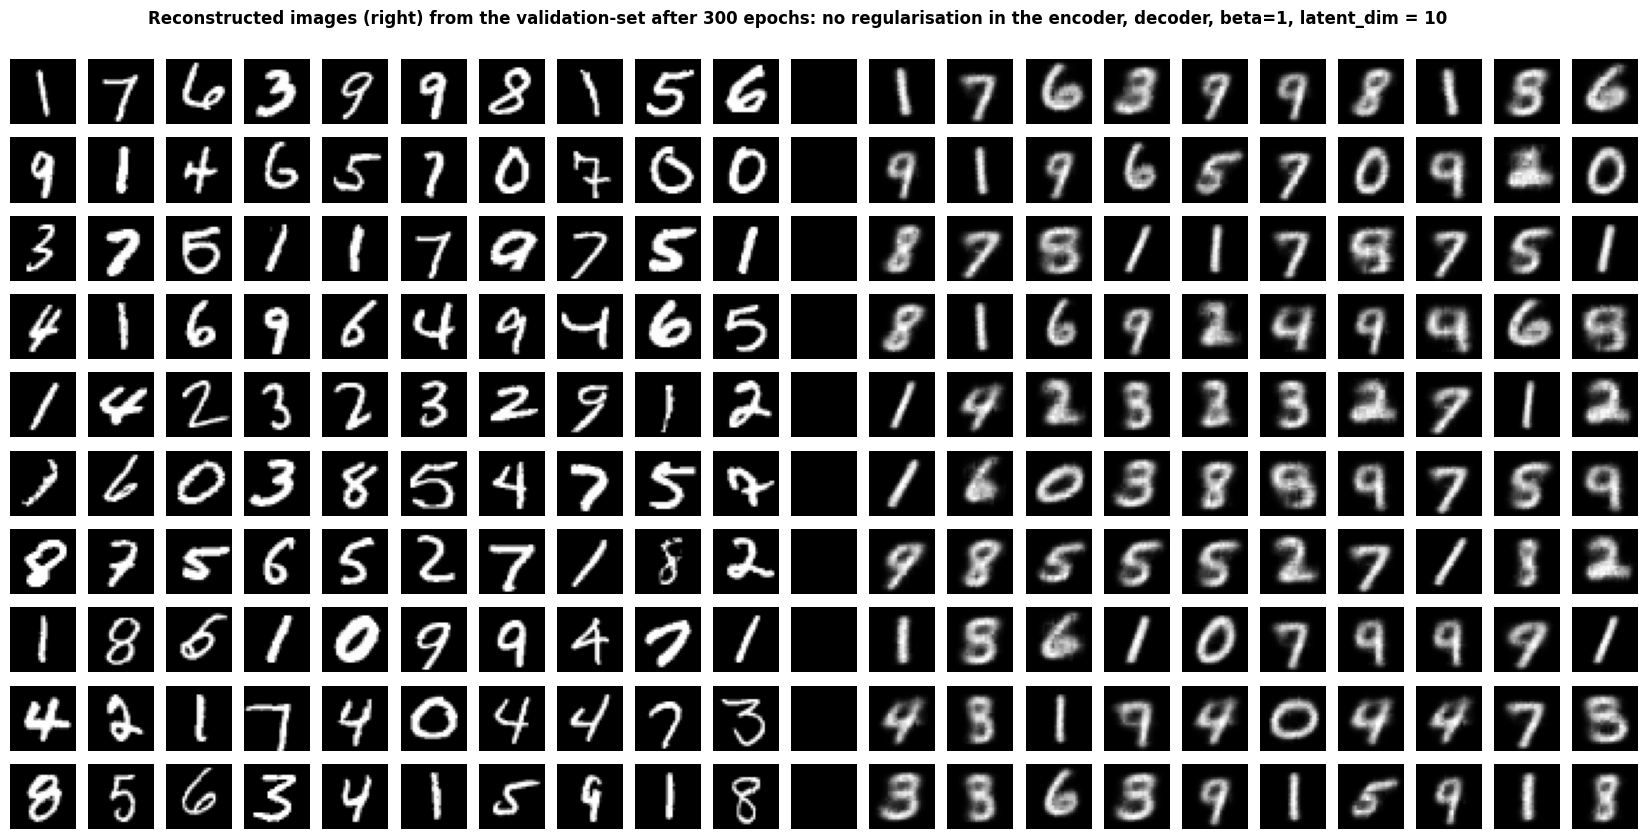

In [17]:
plot_reconstruction(img_valid,'validation',123,300)

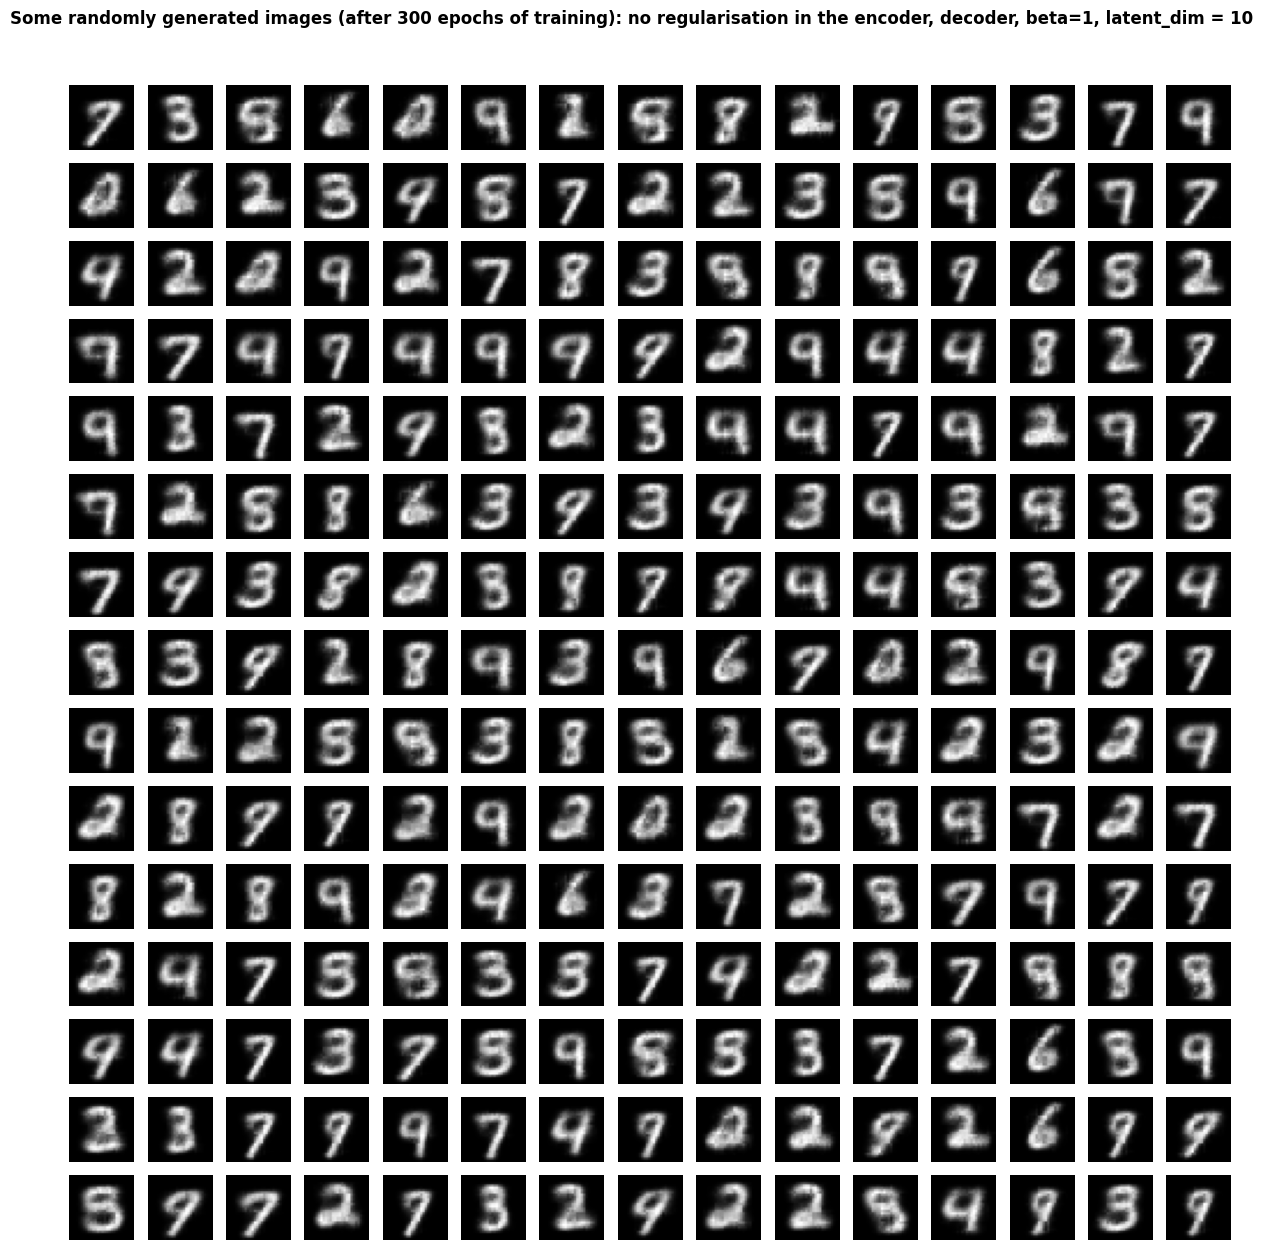

In [20]:
plot_generated(1,15,444,300)

## **beta=3**

In [8]:
beta=3

def vae_loss_5(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [9]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=50000, decay_rate=0.99, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_5)

In [ ]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=500, steps_per_epoch=None)

Epoch 1/500
625/625 [==============================] - 65s 95ms/step - loss: 240.5924 - val_loss: 200.3446
Epoch 2/500
256/625 [===========>..................] - ETA: 34s - loss: 198.3599

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plot_reconstruction(img_train,'training',111,500)

In [ ]:
plot_reconstruction(img_valid,'validation',111,500)

In [ ]:
plot_generated(1,15,123,500)